# Обучить сеть, попробовать попрунить, сконвертировать в onnx и запустить в юнити.

In [1]:
import torch
import timm
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms as T


# Обучение сети

### Гиперпараметы

In [2]:
batch_size = 100
num_workers = 1
num_classes = 10
input_size = 64
num_epochs = 10
lr = 0.0001
dummy_input = torch.randn(1, 1, input_size, input_size)
input_names = [ "actual_input" ]
output_names = [ "output" ]
devices = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_transforms = T.Compose([
    T.Resize(input_size),
    T.RandomVerticalFlip(p=0.5),
    T.RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
])
val_transforms = T.Compose([
    T.Resize(input_size),
    T.ToTensor(),
])

### Датасет

In [3]:
training_data = datasets.FashionMNIST(root="../datasets",train=True,download=True,transform=train_transforms)
test_data = datasets.FashionMNIST(root="../datasets",train=False,download=True,transform=val_transforms)
train_dataloader = DataLoader(training_data, batch_size=batch_size, num_workers=num_workers, pin_memory=True, drop_last=True, shuffle=True,)
val_dataloader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, pin_memory=True, drop_last=True, shuffle=False)

### Пример данных

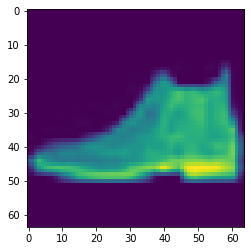

In [4]:
image, label = test_data.__getitem__(0)
image_cat = image.numpy().transpose((1, 2, 0))
plt.imshow(image_cat)
plt.show()

### Модель

In [5]:
model = timm.create_model("resnet18", pretrained=True, in_chans = 1, num_classes=num_classes).to(devices)
criterion=torch.nn.CrossEntropyLoss()
optimizer =torch.optim.AdamW(model.parameters(), lr = lr)

### Обучение

In [6]:
def train(model, optimizer, criterion, num_epochs = 1):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)
        for phase in ["T","V"]:
            if phase == "T":
                dataloader = train_dataloader
                model=model.train()
            else:
                dataloader = val_dataloader
                model=model.eval()      
            epoch_inputs = 0
            correct = 0
            total = 0
            for inputs, labels in dataloader:
                inputs = inputs.to(devices)
                labels = labels.to(devices)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'T'):
                    out = model(inputs)
                    loss = criterion(out, labels)
                    _, predicted = torch.max(out.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    epoch_inputs += loss.item()
                    if phase == "T":
                        loss.backward()
                        optimizer.step()
            print(f"{phase} loss = {epoch_inputs / len(dataloader):0.3f}, Acc = {100 * correct / total: 0.3f}")
    return model


In [7]:
model = train(model, optimizer, criterion, num_epochs)

Epoch 1/10
----------
T loss = 0.359, Acc =  87.538
V loss = 0.249, Acc =  91.130
Epoch 2/10
----------
T loss = 0.222, Acc =  92.027
V loss = 0.227, Acc =  91.770
Epoch 3/10
----------
T loss = 0.186, Acc =  93.353
V loss = 0.206, Acc =  92.590
Epoch 4/10
----------
T loss = 0.163, Acc =  94.158
V loss = 0.192, Acc =  93.380
Epoch 5/10
----------
T loss = 0.148, Acc =  94.655
V loss = 0.202, Acc =  92.810
Epoch 6/10
----------
T loss = 0.136, Acc =  95.160
V loss = 0.185, Acc =  93.300
Epoch 7/10
----------
T loss = 0.121, Acc =  95.602
V loss = 0.196, Acc =  93.350
Epoch 8/10
----------
T loss = 0.109, Acc =  96.070
V loss = 0.191, Acc =  93.710
Epoch 9/10
----------
T loss = 0.103, Acc =  96.325
V loss = 0.195, Acc =  93.470
Epoch 10/10
----------
T loss = 0.096, Acc =  96.542
V loss = 0.219, Acc =  93.070


## Конвертация в ONNX

In [8]:
model.eval()
model.to("cpu")
torch.onnx.export(model,
                 dummy_input,
                 "resnet18_origen.onnx",
                 verbose=False,
                 input_names=input_names,
                 output_names=output_names,
                 export_params=True,
                 )

# Прунинг готовой модели

In [9]:
# !pip install nni==2.7
# !pip install tensorboard

In [10]:
import nni
from nni.algorithms.compression.v2.pytorch.pruning import TaylorFOWeightPruner
from nni.compression.pytorch import ModelSpeedup
import os

### Расчет маски для прунинга алгоритмом TaylorFOWeight и обрезка модели

In [ ]:
traced_optimizer = nni.trace(torch.optim.Adam)(model.parameters())
config_list = [{ 'sparsity': 0.8, 'op_types': ['Conv2d'] }]
model.to(devices)
pruner = TaylorFOWeightPruner(model, config_list, train, traced_optimizer, criterion, training_batches=batch_size)
masked_model, masks = pruner.compress()
pruner._unwrap_model()
model.eval()
ms = ModelSpeedup(model.to(devices), dummy_input.to(devices), masks)
ms.speedup_model()

### Дообучение

In [12]:
criterion=torch.nn.CrossEntropyLoss()
optimizer =torch.optim.AdamW(model.parameters(), lr = lr)
model.to(devices)
model = train(model, optimizer, criterion, num_epochs)

Epoch 1/10
----------
T loss = 0.426, Acc =  84.898
V loss = 0.345, Acc =  87.480
Epoch 2/10
----------
T loss = 0.291, Acc =  89.638
V loss = 0.266, Acc =  90.020
Epoch 3/10
----------
T loss = 0.259, Acc =  90.663
V loss = 0.269, Acc =  89.930
Epoch 4/10
----------
T loss = 0.237, Acc =  91.378
V loss = 0.272, Acc =  90.010
Epoch 5/10
----------
T loss = 0.218, Acc =  92.063
V loss = 0.232, Acc =  91.450
Epoch 6/10
----------
T loss = 0.208, Acc =  92.458
V loss = 0.232, Acc =  91.450
Epoch 7/10
----------
T loss = 0.196, Acc =  92.978
V loss = 0.233, Acc =  91.300
Epoch 8/10
----------
T loss = 0.190, Acc =  93.063
V loss = 0.233, Acc =  91.600
Epoch 9/10
----------
T loss = 0.180, Acc =  93.435
V loss = 0.231, Acc =  91.760
Epoch 10/10
----------
T loss = 0.172, Acc =  93.797
V loss = 0.218, Acc =  91.830


### Конвертация в ONNX

In [13]:
model.eval()
model.to("cpu")
torch.onnx.export(model,
                 dummy_input,
                 "resnet18_prun_80p.onnx",
                 verbose=False,
                 input_names=input_names,
                 output_names=output_names,
                 export_params=True,
                 )

# Сравнение результатов

In [20]:
stats1 = os.stat('resnet18_origen.onnx')
stats2 = os.stat('resnet18_prun_80p.onnx')

print(f"Размер сети до прунинга = {stats1.st_size / 1024 / 1024:0.0f} mb, после = {stats2.st_size / 1024 / 1024:0.0f} mb")

Размер сети до прунинга = 43 mb, после = 4 mb
